In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import glob
import tarfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from transformers import get_scheduler
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.optim import AdamW

In [2]:
!gdown 1jxJNYCc3K_ad-_iT65MZob8nRWKCItV5

Downloading...
From: https://drive.google.com/uc?id=1jxJNYCc3K_ad-_iT65MZob8nRWKCItV5
To: /home/jovyan/work/Projects/EEG_Report_Classification/TUAB_txt_relabelled.tar
100%|██████████████████████████████████████| 12.3M/12.3M [00:01<00:00, 10.4MB/s]


In [3]:
tar = tarfile.open("./TUAB_txt_relabelled.tar")
tar.extractall()
tar.close()

In [48]:
main_dataset_dir = '/home/jovyan/work/Projects/EEG_Report_Classification/TUAB_txt_relabelled/v2.0.0/edf/'
train_dataset_dir = main_dataset_dir + 'train/'
test_dataset_dir = main_dataset_dir + 'eval/'
saved_models_dir = "/home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/TinyBERT/"

In [38]:
# uses the tinybert tokenizer
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

def read_text_file(file_path):
    encodings = ['utf-8', 'iso-8859-1', 'windows-1252', 'ascii']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            continue
    return None


def preprocess_text(text):
    # Encode the texts using the TinyBERT tokenizer
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=512,  # Set maximum length to 512 tokens
        truncation=True,  # Truncate longer sequences
        padding='max_length',  # Pad shorter sequences
        return_attention_mask=True,
        return_tensors='pt'  # Return PyTorch tensors
    )
    return encoded_text['input_ids'], encoded_text['attention_mask']


class TextReportsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = glob.glob(os.path.join(root_dir, '**/*.txt'), recursive=True)
        self.data = []
        self.labels = []
        
        for file_path in self.file_paths:
            if 'abnormal' in file_path:
                self.labels.append(1)
            elif 'normal' in file_path:
                self.labels.append(0)
            else:
                continue  # or raise an error
            text = read_text_file(file_path)
            if self.transform:
                text = self.transform(text)
            self.data.append(text)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, attention_mask = self.data[idx]
        label = self.labels[idx]
        input_ids = input_ids.squeeze()
        attention_mask = attention_mask.squeeze()
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}


In [26]:
train_dataset = TextReportsDataset(root_dir=train_dataset_dir, transform=preprocess_text)
test_dataset = TextReportsDataset(root_dir=test_dataset_dir, transform=preprocess_text)

# Splitting train dataset into train and validation sets (80/20 split)
num_train = int(len(train_dataset) * 0.8)
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])


In [35]:
# Create DataLoaders for train, validation, and test
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = BertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=2)

# Choose device available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = AdamW(model.parameters(), lr=5e-5)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:

def train_and_validate(model, train_dataloader, val_dataloader, optimizer, device, epochs=3, saved_models_path=saved_models):
    """Train and validate the model.
    
    Args:
        model (torch.nn.Module): The model to train and validate.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for the model.
        device (torch.device): Device to run the model computation.
        epochs (int): Number of epochs to train the model.
        saved_models_path (str): Directory path where the model will be saved.
    """
    model = model.to(device)
    best_val_accuracy = 0

    # Get the model name from its class
    model_name = model.__class__.__name__

    total_steps = len(train_dataloader) * epochs
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation Phase
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_examples = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                total_correct += (predictions == batch['labels']).sum().item()
                total_examples += batch['labels'].size(0)

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_correct / total_examples
        print(f"Average validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Construct the filename for saving the model
            save_path = os.path.join(saved_models_path, f"{model_name}_best_model.pth")
            torch.save(model.state_dict(), save_path)
            print(f"Saved improved model at {save_path}")

In [ ]:
def clip_gradients(model, max_norm):
    """Clips the gradients computed during backpropagation to have a maximum norm of `max_norm`."""
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

def add_noise(model, noise_level):
    """Adds Gaussian noise to the gradients to ensure differential privacy."""
    for param in model.parameters():
        if param.grad is not None:
            noise = torch.randn_like(param.grad) * noise_level
            param.grad += noise

def train_and_validate_with_privacy(model, train_dataloader, val_dataloader, optimizer, device, epochs=3, max_grad_norm=1.0, noise_level=0.1, saved_models_path=saved_models_dir):
    model = model.to(device)
    best_val_accuracy = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # Add tqdm for visual progress on training
        train_progress = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training")
        for batch in train_progress:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            
            # Clip gradients to prevent large updates that could reveal data specifics
            clip_gradients(model, max_grad_norm)
            
            # Add Gaussian noise to gradients for differential privacy
            add_noise(model, noise_level)
            
            optimizer.step()

            total_loss += loss.item()
            # Update progress bar with the current loss
            train_progress.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation Phase
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_examples = 0
        # Add tqdm for visual progress on validation
        val_progress = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Validation")
        with torch.no_grad():
            for batch in val_progress:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                total_correct += (predictions == batch['labels']).sum().item()
                total_examples += batch['labels'].size(0)
                # Update progress bar with validation accuracy
                val_progress.set_postfix({'val_acc': f'{(total_correct/total_examples):.4f}'})

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_correct / total_examples
        print(f"Average validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_path = os.path.join(saved_models_path, f"{model.__class__.__name__}_best_model.pth")
            torch.save(model.state_dict(), save_path)
            print(f"Saved improved model at {save_path}")

In [46]:
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    device=device,
    epochs=5
)

Epoch 1/5 - Training: 100%|██████████| 272/272 [00:16<00:00, 16.58it/s]


Average training loss: 0.0634


Epoch 1/5 - Validation: 100%|██████████| 68/68 [00:01<00:00, 49.77it/s]


Average validation loss: 0.0157
Validation accuracy: 0.9963
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/BertForSequenceClassification_best_model.pth


Epoch 2/5 - Training: 100%|██████████| 272/272 [00:16<00:00, 16.54it/s]


Average training loss: 0.0279


Epoch 2/5 - Validation: 100%|██████████| 68/68 [00:01<00:00, 49.72it/s]


Average validation loss: 0.0184
Validation accuracy: 0.9945


Epoch 3/5 - Training: 100%|██████████| 272/272 [00:16<00:00, 16.34it/s]


Average training loss: 0.0300


Epoch 3/5 - Validation: 100%|██████████| 68/68 [00:01<00:00, 48.63it/s]


Average validation loss: 0.0173
Validation accuracy: 0.9945


Epoch 4/5 - Training: 100%|██████████| 272/272 [00:16<00:00, 16.27it/s]


Average training loss: 0.0138


Epoch 4/5 - Validation: 100%|██████████| 68/68 [00:01<00:00, 48.74it/s]


Average validation loss: 0.0109
Validation accuracy: 0.9963


Epoch 5/5 - Training: 100%|██████████| 272/272 [00:16<00:00, 16.30it/s]


Average training loss: 0.0120


Epoch 5/5 - Validation: 100%|██████████| 68/68 [00:01<00:00, 48.78it/s]


Average validation loss: 0.0058
Validation accuracy: 0.9982
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/BertForSequenceClassification_best_model.pth


In [ ]:
train_and_validate_with_privacy(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    device=device,
    epochs=20
)

In [47]:
def evaluate_model_and_plot(model, dataloader, device):
    """Evaluate the model and plot metrics and confusion matrix."""
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    class_report = classification_report(true_labels, predictions, target_names=['Normal', 'Abnormal'], output_dict=True)
    conf_matrix = confusion_matrix(true_labels, predictions)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=['Normal', 'Abnormal']))

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {"accuracy": accuracy, "report": class_report, "confusion_matrix": conf_matrix}

In [49]:
# Step 1: Recreate the model architecture
model = BertForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=2,  # Ensure this matches the setup during training
    output_attentions=False,
    output_hidden_states=False,
)

# Step 2: Load the saved model weights
model_path = saved_models_dir+'BertForSequenceClassification_best_model.pth'
model.load_state_dict(torch.load(model_path))

# Step 3: Prepare the model for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

Accuracy: 0.9818840579710145
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       150
    Abnormal       0.97      0.99      0.98       126

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



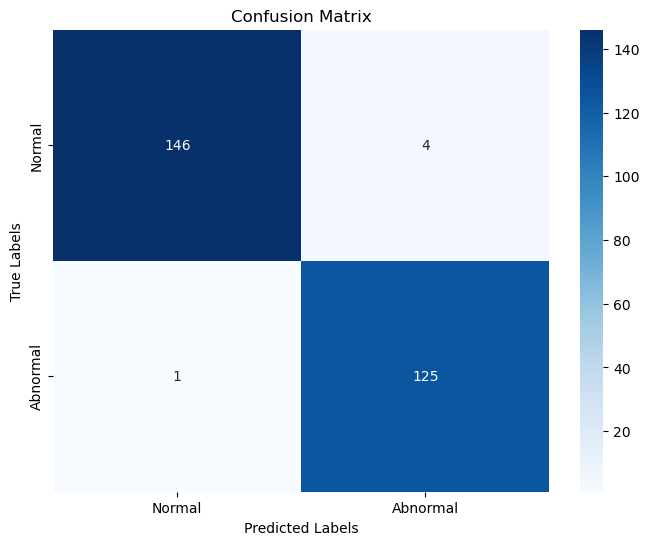

In [50]:
# model evaluation finally done here
results = evaluate_model_and_plot(model, test_dataloader, device)